In [1]:
import pandas as pd
import numpy as np
from scipy.stats import truncnorm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor, DMatrix
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import random
from conditionalconformal import CondConf
import itertools
import math

In [2]:
np.random.seed(1)

dimension_z = 100
dimension_x = 100
number_z = 30
# Generating 30 vectors, each with 100 dimensions
z_domain = np.random.normal(size=(number_z, dimension_z))

# Generating beta_1 and beta_2
beta_1 = np.random.uniform(-1, 1, dimension_x)
beta_2 = np.random.uniform(-1, 1, dimension_z)


In [3]:

def generate_function(beta_1, beta_2):


    def function_1(X, Z):
        epsilon = truncnorm.rvs(-1, 1)  # Generate epsilon from a truncated normal distribution
        T = (np.dot(beta_1.T, X) ** 2) * (np.sin(np.dot(beta_2.T, Z)) ** 2) + 1 + epsilon
        return T

    return function_1

function_1 = generate_function(beta_1, beta_2)

In [7]:
def prepare_data_for_regression(df):
    # Extracting X and Z and converting them into suitable format for regression
    X_data = np.array(df['X'].tolist())
    Z_data = np.array(df['Z'].tolist())

    # Concatenating X and Z
    combined_data = np.concatenate([X_data, Z_data], axis=1)

    return combined_data


In [10]:
def phi_fn(feature):
    scalar_values = np.array(feature[:,dimension_x:(dimension_x+dimension_z)])#len 500

    # Initialize the indicator matrix
    matrix = np.zeros((len(np.array(feature[:,1])), number_z))

    # Fill in the indicator matrix
    for i, value in enumerate(scalar_values):
        for j in range(0, number_z):
            if  np.array_equal(value, z_domain[j]):
                matrix[i, j] = 1

    return matrix

In [11]:
np.random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]

def conformal_predict_z_0(alpha=0.1, m=100, Z_new=Z_new, N=1000, t=200):
    IR = []
    for j in range(t):
        data_points = []
        for _ in range(N):
            # Randomly select a vector from z_domain to be Z
            Z = z_domain[np.random.randint(z_domain.shape[0])]

            # Compute the mean of the square of Z
            mean_x = np.mean(Z**2)

            # Generate a 150-dimensional vector X from a normal distribution with mean mean_x and variance 1
            X = np.random.normal(mean_x, 1, dimension_x)

            # Compute T_1 and T_2 using the generated functions
            T_1 = function_1(X, Z)
            #T_2 = function_2(X, Z)

            # Append the data point (X, Z, T_1, T_2) to the list
            data_points.append([X, Z, T_1])
        # Split the data into D_cali and D_train
        D_cali = pd.DataFrame(data_points[:N//2], columns=["X", "Z", "T_1"])
        D_train = pd.DataFrame(data_points[N//2:], columns=["X", "Z", "T_1"])

        # Preparing data for regression
        X_train = prepare_data_for_regression(D_train)
        # Extracting T_1
        T_1_train = D_train['T_1']
        # Using a polynomial model (Let's start with a 2nd degree polynomial)
        poly = PolynomialFeatures(degree=2)
        X_train_poly = poly.fit_transform(X_train)
        # Training the model
        model = LinearRegression()
        model.fit(X_train_poly, T_1_train)

        score_fn = lambda feature,  y : abs(y - model.predict(poly.transform(pd.DataFrame(feature))))
        
        condCovProgram = CondConf(score_fn, phi_fn, {})
        condCovProgram.setup_problem(prepare_data_for_regression(D_cali),D_cali['T_1'].to_numpy())
        
        data_points_new = []
        for _ in range(m):
            # Compute the mean of the square of Z
            mean_x_new = np.mean(Z_new**2)
            # Generate a 150-dimensional vector X from a normal distribution with mean mean_x and variance 1
            X_new = np.random.normal(mean_x_new, 1, dimension_x)
            # Compute T_1 and T_2 using the generated functions
            T_1_new = function_1(X_new, Z_new)
            #T_2_new = function_2(X_new, Z_new)

            # Append the data point (X, Z, T_1, T_2) to the list
            data_points_new.append([X_new, Z_new, T_1_new])

        # Split the data into D_cali and D_train
        D_new = pd.DataFrame(data_points_new, columns=["X", "Z", "T_1"])
        
        X_neww = prepare_data_for_regression(D_new)
        T_1_new= D_new['T_1']
        X_new_poly = poly.transform(X_neww)
        T_1_pred_new = model.predict(X_new_poly)

        Xtest = np.array([prepare_data_for_regression(D_new)[10,:]])
        d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x) 
        
        # Calculate intervals
        hat_t_L = T_1_pred_new - d
        hat_t_U = T_1_pred_new + d 
        IR.append(np.mean((hat_t_L <= T_1_new) & (T_1_new <= hat_t_U)))
        

            
    return IR, d

4333.60425901413


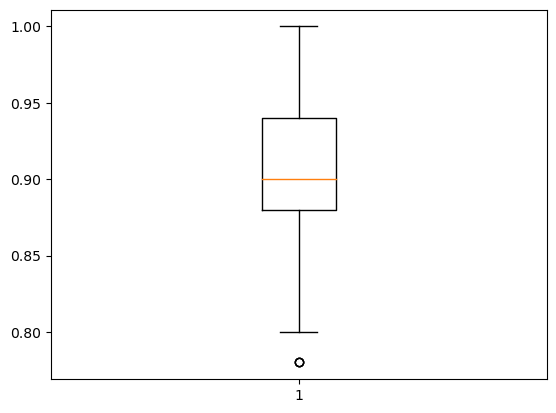

In [23]:
import time

np.random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]

IR, d = conformal_predict_z_0(alpha=0.1, m=50, Z_new=Z_new, N=10000, t=200)

###
plt.boxplot(IR, patch_artist=True, medianprops=dict(color="black"), boxprops=dict(facecolor='lightblue'))
plt.yticks( fontsize=10)
plt.xticks([1], [''])  # Setting x-axis label to an empty string
plt.axhline(y=0.9, color='red', linestyle='-', label='', linewidth=1)
plt.xlabel('Random z0', fontsize=15)
plt.ylabel('Coverage', fontsize=15)
plt.yticks( fontsize=15)


In [13]:
#########################################################################

IR = [0.84, 0.9, 0.9, 0.88, 0.96, 0.94, 0.88, 0.88, 0.96, 0.82, 0.94, 0.94, 0.92, 0.88, 0.96, 0.9, 0.9, 0.92, 0.9, 0.92, 0.88, 0.9, 0.8, 0.86, 0.92, 0.96, 0.86, 0.9, 0.9, 0.88, 0.86, 0.98, 0.98, 0.9, 0.9, 0.88, 0.9, 0.9, 0.82, 0.98, 0.88, 0.9, 0.86, 0.92, 0.84, 1.0, 0.9, 0.88, 0.88, 0.94, 0.92, 0.94, 0.92, 0.9, 0.9, 0.92, 0.94, 0.82, 0.9, 0.9, 0.94, 1.0, 0.98, 0.94, 0.94, 0.88, 0.88, 0.94, 0.88, 0.88, 0.94, 0.88, 0.86, 0.9, 0.92, 0.92, 0.92, 0.9, 0.92, 0.86, 0.94, 0.9, 0.96, 0.88, 0.88, 0.86, 0.9, 0.96, 0.92, 0.86, 0.96, 0.98, 0.9, 0.88, 0.92, 0.84, 0.96, 0.94, 0.96, 0.92, 0.96, 0.9, 0.94, 0.9, 0.94, 0.78, 0.9, 0.94, 0.9, 0.94, 0.84, 0.82, 0.92, 0.84, 0.88, 1.0, 0.98, 0.92, 0.94, 0.86, 0.92, 0.86, 0.88, 0.96, 0.88, 0.82, 0.86, 0.9, 0.92, 0.9, 0.92, 0.96, 0.96, 0.9, 0.88, 0.96, 0.94, 0.88, 0.9, 0.96, 0.96, 0.94, 0.84, 0.96, 0.84, 0.96, 0.9, 0.86, 0.98, 0.9, 0.96, 0.94, 0.92, 0.92, 0.88, 0.82, 0.84, 0.86, 0.86, 0.92, 0.92, 0.78, 0.92, 0.84, 0.92, 0.96, 0.88, 0.9, 0.9, 0.86, 0.9, 0.92, 0.78, 0.98, 0.94, 0.92, 0.92, 0.88, 0.94, 0.9, 0.88, 0.92, 0.88, 0.8, 0.84, 0.9, 0.94, 0.86, 0.84, 0.82, 0.88, 0.92, 0.84, 0.84, 0.9, 0.92, 0.86, 0.86, 0.96, 0.88]


(array([0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

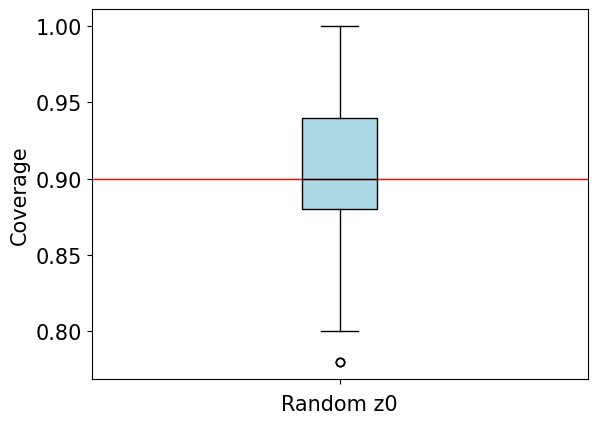

In [14]:
#########################################################################
plt.boxplot(IR, patch_artist=True, medianprops=dict(color="black"), boxprops=dict(facecolor='lightblue'))
plt.yticks( fontsize=10)
plt.xticks([1], [''])  # Setting x-axis label to an empty string
plt.axhline(y=0.9, color='red', linestyle='-', label='', linewidth=1)
plt.xlabel('Random z0', fontsize=15)
plt.ylabel('Coverage', fontsize=15)
plt.yticks( fontsize=15)

In [15]:
np.random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
def conformal_predict(alpha=0.1, m=100, Z_new=Z_new, N = 1000):
    data_points = []
    for _ in range(N):
        # Randomly select a vector from z_domain to be Z
        Z = z_domain[np.random.randint(z_domain.shape[0])]

        # Compute the mean of the square of Z
        mean_x = np.mean(Z**2)

        # Generate a 150-dimensional vector X from a normal distribution with mean mean_x and variance 1
        X = np.random.normal(mean_x, 1, dimension_x)

        # Compute T_1 and T_2 using the generated functions
        T_1 = function_1(X, Z)
        #T_2 = function_2(X, Z)

        # Append the data point (X, Z, T_1, T_2) to the list
        data_points.append([X, Z, T_1])
    # Split the data into D_cali and D_train
    D_cali = pd.DataFrame(data_points[:N//2], columns=["X", "Z", "T_1"])
    D_train = pd.DataFrame(data_points[N//2:], columns=["X", "Z", "T_1"])

    # Preparing data for regression
    X_train = prepare_data_for_regression(D_train)
    # Extracting T_1
    T_1_train = D_train['T_1']
    # Using a polynomial model (Let's start with a 2nd degree polynomial)
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    # Training the model
    model = LinearRegression()
    model.fit(X_train_poly, T_1_train)

    score_fn = lambda feature,  y : abs(y - model.predict(poly.transform(pd.DataFrame(feature))))

    condCovProgram = CondConf(score_fn, phi_fn, {})
    condCovProgram.setup_problem(prepare_data_for_regression(D_cali),D_cali['T_1'].to_numpy())

    data_points_new = []
    for _ in range(m):
        # Compute the mean of the square of Z
        mean_x_new = np.mean(Z_new**2)
        # Generate a 150-dimensional vector X from a normal distribution with mean mean_x and variance 1
        X_new = np.random.normal(mean_x_new, 1, dimension_x)
        # Compute T_1 and T_2 using the generated functions
        T_1_new = function_1(X_new, Z_new)
        #T_2_new = function_2(X_new, Z_new)

        # Append the data point (X, Z, T_1, T_2) to the list
        data_points_new.append([X_new, Z_new, T_1_new])

    # Split the data into D_cali and D_train
    D_new = pd.DataFrame(data_points_new, columns=["X", "Z", "T_1"])

    X_neww = prepare_data_for_regression(D_new)
    T_1_new= D_new['T_1']
    X_new_poly = poly.transform(X_neww)
    T_1_pred_new = model.predict(X_new_poly)

    Xtest = np.array([prepare_data_for_regression(D_new)[10,:]])
    d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x) 
     
    reserve_price = T_1_pred_new - d
    virtual_value = np.array(T_1_new) * (np.array(T_1_new) > reserve_price)

    # Find the index(es) of the maximum virtual value
    max_virtual_value_indexes = np.where(virtual_value == np.max(virtual_value))[0]
    winner = None
    if len(max_virtual_value_indexes) > 1:
    # Check the reserve price for the max virtual value indexes
        max_reserve_price_indexes = np.where(reserve_price[max_virtual_value_indexes] == np.max(reserve_price[max_virtual_value_indexes]))[0]

        if len(max_reserve_price_indexes) > 1:
        # If multiple maximums, choose one at random
            winner = np.random.choice(max_virtual_value_indexes[max_reserve_price_indexes])
        else:
        # If only one maximum
            winner = max_virtual_value_indexes[max_reserve_price_indexes[0]]
    else:
    # If only one maximum virtual value
        winner = max_virtual_value_indexes[0]

    sorted_virtual_value = np.sort(virtual_value)[::-1]
    payment = max(0, sorted_virtual_value[1], reserve_price[winner])
    max_welfare = np.max(np.array(T_1_new))
    
    return payment, payment/max_welfare, payment - np.sort(np.array(T_1_new))[::-1][1], np.sort(np.array(T_1_new))[::-1][1], max_welfare

In [74]:

np.random.seed(1)
m_0 = 50
IR_compare = []
np.random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]

for i in range(200):
    result = conformal_predict(alpha=0.1, m=m_0,  Z_new=Z_new, N = 10000)
    IR_compare.append(result[2]) #IR_compare_100_100

   

5848.689967870712


In [ ]:
plt.xlabel('Random z0', fontsize=15)
plt.ylabel('Revenue Difference', fontsize=15)

###
plt.boxplot(IR_compare, patch_artist=True, boxprops=dict(facecolor='lightblue'),  # Box color set to blue
            medianprops=dict(color="black"))
plt.yticks( fontsize=15.603240200456185)
plt.xticks([1], [''])  # Setting x-axis label to an empty string
plt.axhline(y=0, color='red', linestyle='-', label='', linewidth=1)
plt.ylim(-5,50)

In [17]:
IR_compare_100_100 = [28.141221441922426, 0.0, 0.0, 36.81301367524247, 0.0, 0.0, 0.0, 7.193945827932055, 27.759587556683755, 0.0, 0.0, 0.0, 0.0, 43.6903142168959, 27.124457941787398, 18.19804041608387, 24.68708660984379, 0.0, 0.0, 0.0, 0.0, 0.0, 33.96292725793205, 0.0, 18.294832980663614, 0.0, 0.0, 0.0, 0.0, 0.0, 44.461723451075954, 0.0, 0.0, 28.474422829004595, 0.0, 0.0, 0.0, 0.0, 0.0, 25.042297198756046, 126.03122123179799, 0.0, 0.0, 0.0, 0.0, 236.12606894309772, 5.822674322612443, 42.184219408924264, 0.0, 0.0, 28.84636674607418, 62.124383953367385, 56.68201332675358, 139.7853397171707, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6493996098413959, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 140.0337304644412, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 63.904504915600114, 0.0, 0.0, 0.0, 39.64702671002232, 0.0, 60.38997610829898, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.07726009150707, 28.817608487946643, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.191614097807076, 0.0, 0.0, 0.0, 0.0, 0.0, 29.108106510107007, 87.77898562479328, 0.0, 0.0, 121.85333909533011, 0.0, 39.645948471172744, 0.0, 0.0, 12.82819975560676, 0.0, 0.0, 73.13050955140034, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.697719346301767, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.193522578551551, 0.0, 47.974829070094984, 0.0, 0.0, 0.0, 0.0, 0.0, 85.92278668595486, 0.0, 19.74590137113404, 0.0, 42.71772681389069, 0.0, 0.0, 7.669208641802811, 26.916662581706987, 19.026777563807286, 0.0, 0.33900377354871125, 0.0, 31.833586540185365, 0.0, 0.0, 0.0, 3.412803485391123, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.863927674073182, 176.9438000171254, 27.555459847406382, 0.0, 28.727935777912137, 0.0, 120.57892908555448, 27.234283808242708, 6.451318019787948, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 113.38907914303888, 0.0, 27.605539825058145, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 151.11658684495671, 124.9893994830619, 0.0, 0.0]

(-5.0, 50.0)

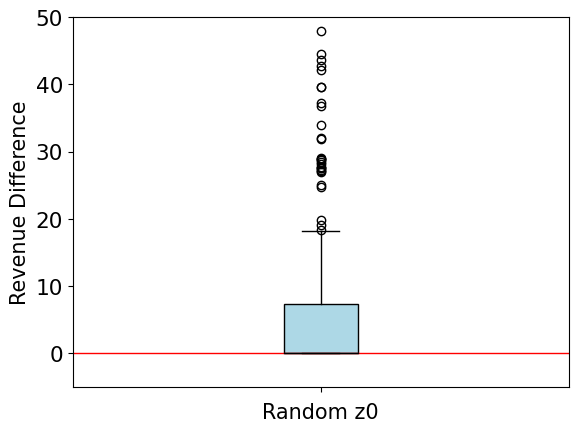

In [18]:
plt.xlabel('Random z0', fontsize=15)
plt.ylabel('Revenue Difference', fontsize=15)
plt.boxplot(IR_compare_100_100, patch_artist=True, boxprops=dict(facecolor='lightblue'),  # Box color set to blue
            medianprops=dict(color="black"))
plt.yticks( fontsize=15.603240200456185)
plt.xticks([1], [''])  # Setting x-axis label to an empty string
plt.axhline(y=0, color='red', linestyle='-', label='', linewidth=1)
plt.ylim(-5,50)

In [ ]:
def conformal_predict(alpha=0.1, m=100, Z_new=Z_new):
   

    score_fn = lambda feature,  y : abs(y - model.predict(poly.transform(pd.DataFrame(feature))))

    condCovProgram = CondConf(score_fn, phi_fn, {})
    condCovProgram.setup_problem(prepare_data_for_regression(D_cali),D_cali['T_1'].to_numpy())

    data_points_new = []
    for _ in range(m):
        # Compute the mean of the square of Z
        mean_x_new = np.mean(Z_new**2)
        # Generate a 150-dimensional vector X from a normal distribution with mean mean_x and variance 1
        X_new = np.random.normal(mean_x_new, 1, dimension_x)
        # Compute T_1 and T_2 using the generated functions
        T_1_new = function_1(X_new, Z_new)
        #T_2_new = function_2(X_new, Z_new)

        # Append the data point (X, Z, T_1, T_2) to the list
        data_points_new.append([X_new, Z_new, T_1_new])

    # Split the data into D_cali and D_train
    D_new = pd.DataFrame(data_points_new, columns=["X", "Z", "T_1"])

    X_neww = prepare_data_for_regression(D_new)
    T_1_new= D_new['T_1']
    X_new_poly = poly.transform(X_neww)
    T_1_pred_new = model.predict(X_new_poly)

    Xtest = np.array([prepare_data_for_regression(D_new)[10,:]])
    d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x) 
     
    reserve_price = T_1_pred_new - d
    virtual_value = np.array(T_1_new) * (np.array(T_1_new) > reserve_price)

    # Find the index(es) of the maximum virtual value
    max_virtual_value_indexes = np.where(virtual_value == np.max(virtual_value))[0]
    winner = None
    if len(max_virtual_value_indexes) > 1:
    # Check the reserve price for the max virtual value indexes
        max_reserve_price_indexes = np.where(reserve_price[max_virtual_value_indexes] == np.max(reserve_price[max_virtual_value_indexes]))[0]

        if len(max_reserve_price_indexes) > 1:
        # If multiple maximums, choose one at random
            winner = np.random.choice(max_virtual_value_indexes[max_reserve_price_indexes])
        else:
        # If only one maximum
            winner = max_virtual_value_indexes[max_reserve_price_indexes[0]]
    else:
    # If only one maximum virtual value
        winner = max_virtual_value_indexes[0]

    sorted_virtual_value = np.sort(virtual_value)[::-1]
    payment = max(0, sorted_virtual_value[1], reserve_price[winner])
    max_welfare = np.max(np.array(T_1_new))
    
    return payment, payment/max_welfare, payment - np.sort(np.array(T_1_new))[::-1][1], np.sort(np.array(T_1_new))[::-1][1], max_welfare

In [20]:

np.random.seed(1)
# 设置 N 的不同值
N_values = [1000, 3000, 5000, 7000, 9000, 11000, 13000]
np.random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
num_runs = 500

# 初始化用于存储结果的字典
results = {"payment": [], "sb_value": [], "max_welfare": []}

# 对于每个 N 值，运行函数 500次并计算平均值
for N in N_values:
    data_points = []
    for _ in range(N):
        # Randomly select a vector from z_domain to be Z
        Z = z_domain[np.random.randint(z_domain.shape[0])]

        # Compute the mean of the square of Z
        mean_x = np.mean(Z**2)

        # Generate a 150-dimensional vector X from a normal distribution with mean mean_x and variance 1
        X = np.random.normal(mean_x, 1, dimension_x)

        # Compute T_1 and T_2 using the generated functions
        T_1 = function_1(X, Z)
        #T_2 = function_2(X, Z)

        # Append the data point (X, Z, T_1, T_2) to the list
        data_points.append([X, Z, T_1])
    # Split the data into D_cali and D_train
    D_cali = pd.DataFrame(data_points[:N//2], columns=["X", "Z", "T_1"])
    D_train = pd.DataFrame(data_points[N//2:], columns=["X", "Z", "T_1"])

    # Preparing data for regression
    X_train = prepare_data_for_regression(D_train)
    # Extracting T_1
    T_1_train = D_train['T_1']
    # Using a polynomial model (Let's start with a 2nd degree polynomial)
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    # Training the model
    model = LinearRegression()
    model.fit(X_train_poly, T_1_train)
    
    payments, sb_values, max_welfares = [], [], []
    for _ in range(num_runs):
        payment, _, _, sb_value, max_welfare = conformal_predict(0.1, 50, Z_new)
        payments.append(payment)
        sb_values.append(sb_value)
        max_welfares.append(max_welfare)
    results["payment"].append(np.mean(payments))
    results["sb_value"].append(np.mean(sb_values))
    results["max_welfare"].append(np.mean(max_welfares))


In [ ]:
###
plt.figure(figsize=(5,5))  # 修改此处以创建正方形的图形
plt.plot(N_values[0:7], results["max_welfare"][0:7], label="Max Welfare", linewidth=2)  # 加粗线条
plt.plot(N_values[0:7], results["payment"][0:7], label="Payment", linewidth=2)  # 加粗线条
plt.plot(N_values[0:7], results["sb_value"][0:7], label="2nd Best Price", linewidth=2)  # 加粗线条


# 设置坐标轴标签和字体大小
plt.xlabel("Number of Previous Data ($N$)", fontsize=15)
plt.ylabel("Expected Values", fontsize=15)

# 设置图例和字体大小
plt.legend(fontsize=15, bbox_to_anchor=(0.38, 0.5), loc='center left')

# 设置横坐标为对数尺度，并确保刻度清晰
#plt.xscale("log")

# 设置刻度标签的字体大小
plt.xticks(N_values[0:7], labels=[str(N) for N in N_values[0:7]], fontsize=30)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.show()

In [21]:
N_values = [1000, 3000, 5000, 7000, 9000, 11000, 13000]
results_100_100_each500 = {'payment': [482.5219299262324,
  486.3341716064692,
  487.01872228182623,
  501.01257170004595,
  500.1600917254209,
  497.63217753219595,
  506.4944375535826],
 'sb_value': [481.6387863927791,
  483.4003916467015,
  478.91419428009215,
  487.07255087038885,
  483.15593585001307,
  478.6368838441756,
  482.77796939341573],
 'max_welfare': [555.9427376335759,
  553.4826626076733,
  552.1807631448181,
  561.2974100661253,
  554.2788626956806,
  548.4565089093745,
  552.7255966699161]}

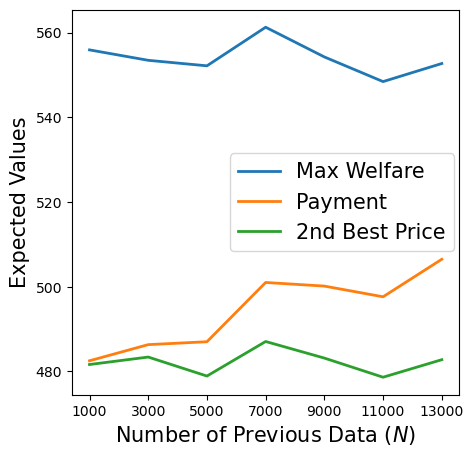

In [22]:

plt.figure(figsize=(5,5))  # 修改此处以创建正方形的图形
plt.plot(N_values[0:7], results_100_100_each500["max_welfare"][0:7], label="Max Welfare", linewidth=2)  # 加粗线条
plt.plot(N_values[0:7], results_100_100_each500["payment"][0:7], label="Payment", linewidth=2)  # 加粗线条
plt.plot(N_values[0:7], results_100_100_each500["sb_value"][0:7], label="2nd Best Price", linewidth=2)  # 加粗线条


# 设置坐标轴标签和字体大小
plt.xlabel("Number of Previous Data ($N$)", fontsize=15)
plt.ylabel("Expected Values", fontsize=15)

# 设置图例和字体大小
plt.legend(fontsize=15, bbox_to_anchor=(0.38, 0.5), loc='center left')

# 设置横坐标为对数尺度，并确保刻度清晰
#plt.xscale("log")

# 设置刻度标签的字体大小
plt.xticks(N_values[0:7], labels=[str(N) for N in N_values[0:7]], fontsize=30)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.show()

In [29]:
np.random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
data_points = []
N = 20000
for _ in range(N):
    # Randomly select a vector from z_domain to be Z
    Z = z_domain[np.random.randint(z_domain.shape[0])]

    # Compute the mean of the square of Z
    mean_x = np.mean(Z**2)

    # Generate a 150-dimensional vector X from a normal distribution with mean mean_x and variance 1
    X = np.random.normal(mean_x, 1, dimension_x)

    # Compute T_1 and T_2 using the generated functions
    T_1 = function_1(X, Z)
    #T_2 = function_2(X, Z)

    # Append the data point (X, Z, T_1, T_2) to the list
    data_points.append([X, Z, T_1])
# Split the data into D_cali and D_train
D_cali = pd.DataFrame(data_points[:N//2], columns=["X", "Z", "T_1"])
D_train = pd.DataFrame(data_points[N//2:], columns=["X", "Z", "T_1"])

# Preparing data for regression
X_train = prepare_data_for_regression(D_train)
# Extracting T_1
T_1_train = D_train['T_1']
# Using a polynomial model (Let's start with a 2nd degree polynomial)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
# Training the model
model = LinearRegression()
model.fit(X_train_poly, T_1_train)
def conformal_predict(alpha=0.1, m=100, Z_new=Z_new):
   

    score_fn = lambda feature,  y : abs(y - model.predict(poly.transform(pd.DataFrame(feature))))

    condCovProgram = CondConf(score_fn, phi_fn, {})
    condCovProgram.setup_problem(prepare_data_for_regression(D_cali),D_cali['T_1'].to_numpy())

    data_points_new = []
    for _ in range(m):
        # Compute the mean of the square of Z
        mean_x_new = np.mean(Z_new**2)
        # Generate a 150-dimensional vector X from a normal distribution with mean mean_x and variance 1
        X_new = np.random.normal(mean_x_new, 1, dimension_x)
        # Compute T_1 and T_2 using the generated functions
        T_1_new = function_1(X_new, Z_new)
        #T_2_new = function_2(X_new, Z_new)

        # Append the data point (X, Z, T_1, T_2) to the list
        data_points_new.append([X_new, Z_new, T_1_new])

    # Split the data into D_cali and D_train
    D_new = pd.DataFrame(data_points_new, columns=["X", "Z", "T_1"])

    X_neww = prepare_data_for_regression(D_new)
    T_1_new= D_new['T_1']
    X_new_poly = poly.transform(X_neww)
    T_1_pred_new = model.predict(X_new_poly)

    Xtest = np.array([prepare_data_for_regression(D_new)[10,:]])
    d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x) 
     
    reserve_price = T_1_pred_new - d
    virtual_value = np.array(T_1_new) * (np.array(T_1_new) > reserve_price)

    # Find the index(es) of the maximum virtual value
    max_virtual_value_indexes = np.where(virtual_value == np.max(virtual_value))[0]
    winner = None
    if len(max_virtual_value_indexes) > 1:
    # Check the reserve price for the max virtual value indexes
        max_reserve_price_indexes = np.where(reserve_price[max_virtual_value_indexes] == np.max(reserve_price[max_virtual_value_indexes]))[0]

        if len(max_reserve_price_indexes) > 1:
        # If multiple maximums, choose one at random
            winner = np.random.choice(max_virtual_value_indexes[max_reserve_price_indexes])
        else:
        # If only one maximum
            winner = max_virtual_value_indexes[max_reserve_price_indexes[0]]
    else:
    # If only one maximum virtual value
        winner = max_virtual_value_indexes[0]

    sorted_virtual_value = np.sort(virtual_value)[::-1]
    payment = max(0, sorted_virtual_value[1], reserve_price[winner])
    max_welfare = np.max(np.array(T_1_new))
    
    return payment, payment/max_welfare, payment - np.sort(np.array(T_1_new))[::-1][1], np.sort(np.array(T_1_new))[::-1][1], max_welfare

In [30]:
conformal_predict(alpha=0.1, m=50, Z_new=Z_new)

(551.5635096511866,
 0.9114489524907926,
 95.27592518562881,
 456.28758446555776,
 605.1501931555058)

In [ ]:

# 设置 m 的不同值
m_values = list(range(50, 301, 50))
np.random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
num_runs = 300

# 初始化用于存储结果的字典
results_m = {"payment": [], "y_value": [], "max_welfare": []}

# 对于每个 m 值，运行函数 100 次并计算平均值
for m in m_values:
    payments, y_values, max_welfares = [], [], []
    for _ in range(num_runs):
        payment, _, _, y_value, max_welfare = conformal_predict(0.1, m, Z_new)
        payments.append(payment)
        y_values.append(y_value)
        max_welfares.append(max_welfare)
    results_m["payment"].append(np.mean(payments))
    results_m["y_value"].append(np.mean(y_values))
    results_m["max_welfare"].append(np.mean(max_welfares))
    


In [ ]:
###
# 绘制结果图
plt.figure(figsize=(8, 8))
plt.plot(m_values, results_m["max_welfare"], label="Max Welfare")
plt.plot(m_values, results_m["payment"], label="Payment")
plt.plot(m_values, results_m["y_value"], label="2nd Best Price")

plt.xlabel("Number of Bidders $(m)$", fontsize=20)
plt.ylabel("Expected Values", fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.title("")#Average Payment, 2nd Best Price, and Max Welfare for Different m Values
# 设置图例和字体大小
#plt.legend(fontsize=20, bbox_to_anchor=(0.0, 1), loc='upper left')
plt.show()

In [25]:
m_values = list(range(50, 301, 50))
results_m = {'payment': [516.4206040770187,
  560.9399411677405,
  588.4649993756782,
  604.9838522132304,
  621.410431282895,
  631.848346561637],
 'y_value': [484.12360847065275,
  537.0604824676701,
  563.4999615061076,
  583.9303755156751,
  595.8811552804456,
  609.1647633996673],
 'max_welfare': [559.675583583263,
  601.8790459541223,
  629.7450160920971,
  645.0508933355716,
  664.9216783574844,
  672.3476850114688]}

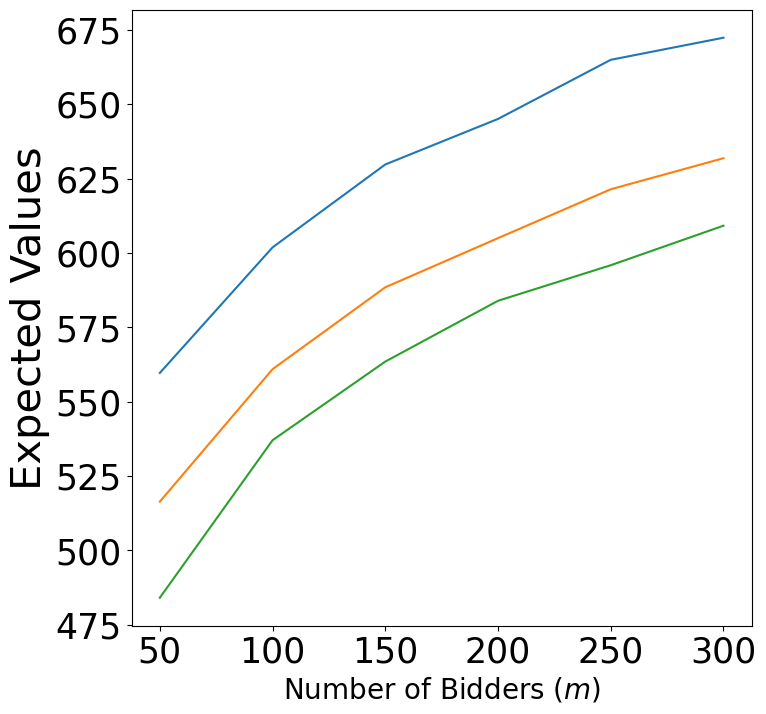

In [26]:
# 绘制结果图
plt.figure(figsize=(8, 8))
plt.plot(m_values, results_m["max_welfare"], label="Max Welfare")
plt.plot(m_values, results_m["payment"], label="Payment")
plt.plot(m_values, results_m["y_value"], label="2nd Best Price")

plt.xlabel("Number of Bidders $(m)$", fontsize=20)
plt.ylabel("Expected Values", fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.title("")#Average Payment, 2nd Best Price, and Max Welfare for Different m Values
# 设置图例和字体大小
#plt.legend(fontsize=20, bbox_to_anchor=(0.0, 1), loc='upper left')
plt.show()